# **Floral diversity clustering** #

# Business goal

The goal of this project is to cluster flower images based on visual similarity. This can assist in organizing large image collections, support pre-analysis, and potentially be used in plant identification applications.
For example, when uploading a new flower image to a photo gallery (such as Google Photos), it could automatically be added to a corresponding folder — similar to how photos of people are grouped today.

In [1]:
!pip install umap-learn;
!pip install opencv-python-headless;

   ---------------------------------------- 0.0/88.8 kB ? eta -:--:--
   ---------------------------------------- 88.8/88.8 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.9 kB ? eta -:--:--
   ---------------------------------------- 56.9/56.9 kB ? eta 0:00:00


In [6]:
import umap
import numpy as np
import random
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import matplotlib.colors as mcolors
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
from sklearn import cluster, mixture
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS
import itertools
from itertools import product
np.random.seed(72)
import warnings
warnings.filterwarnings('ignore')

In [7]:
os.environ["OMP_NUM_THREADS"] = "6"

In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

In [12]:
image_folders = [
    "flower_photos/daisy",
    "flower_photos/dandelion",
    "flower_photos/roses",
    "flower_photos/sunflowers",
    "flower_photos/tulips"
]

image_data = []
for folder in image_folders:
    label = os.path.basename(folder)
    for path in glob.glob(f"{folder}/*.jpg"):
        image_data.append((path, label))

print(f"Found {len(image_data)} images.")

Found 3670 images.


Splitting into test, train and validate

In [13]:
train_paths = []
val_paths = []
test_paths = []
train_paths, val_paths = train_test_split(image_data, test_size=0.3, random_state=72)
train_paths, test_paths = train_test_split(train_paths, test_size=0.3, random_state=72)

print(f"Train: {len(train_paths)}")
print(f"Validate: {len(val_paths)}")
print(f"Test: {len(test_paths)}")

Train: 1798
Validate: 1101
Test: 771


In [14]:
def load_images(paths):
    images = []
    for path in paths:
        try:
            img = Image.open(path).convert('RGB')
            images.append(img)
        except Exception as e:
            print(f"Error {path}: {e}")
    return images

In [15]:
images_train = load_images([path for path, label in train_paths])
labels_train = [label for path, label in train_paths]
images_test = load_images([path for path, label in test_paths])
labels_test = [label for path, label in test_paths]

# EDA

In [16]:
def show_images(images,size=20):
    random.seed(72)
    sample_images = random.sample(images, size)
    
    plt.figure(figsize=(15, 10))
    for i, image in enumerate(sample_images):
        plt.subplot(size//5 + 1, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(f"{size} random images", fontsize=16)
    plt.tight_layout()
    plt.show()

Below are some random images from the dataset.

In [ ]:
show_images(images_train)

In [20]:
image_favorites_folder = [
    "favorites"
]

image_paths_favorites = []
for folder in image_favorites_folder:
    image_paths_favorites.extend(glob.glob(f"{folder}/*.jpg"))

print(f"Found {len(image_paths_favorites)} images.")

Found 23 images.


In [21]:
images_favorites=load_images(image_paths_favorites)

Below are some images we found manually in the dataset, that could be hard to cluster into specific flower category.

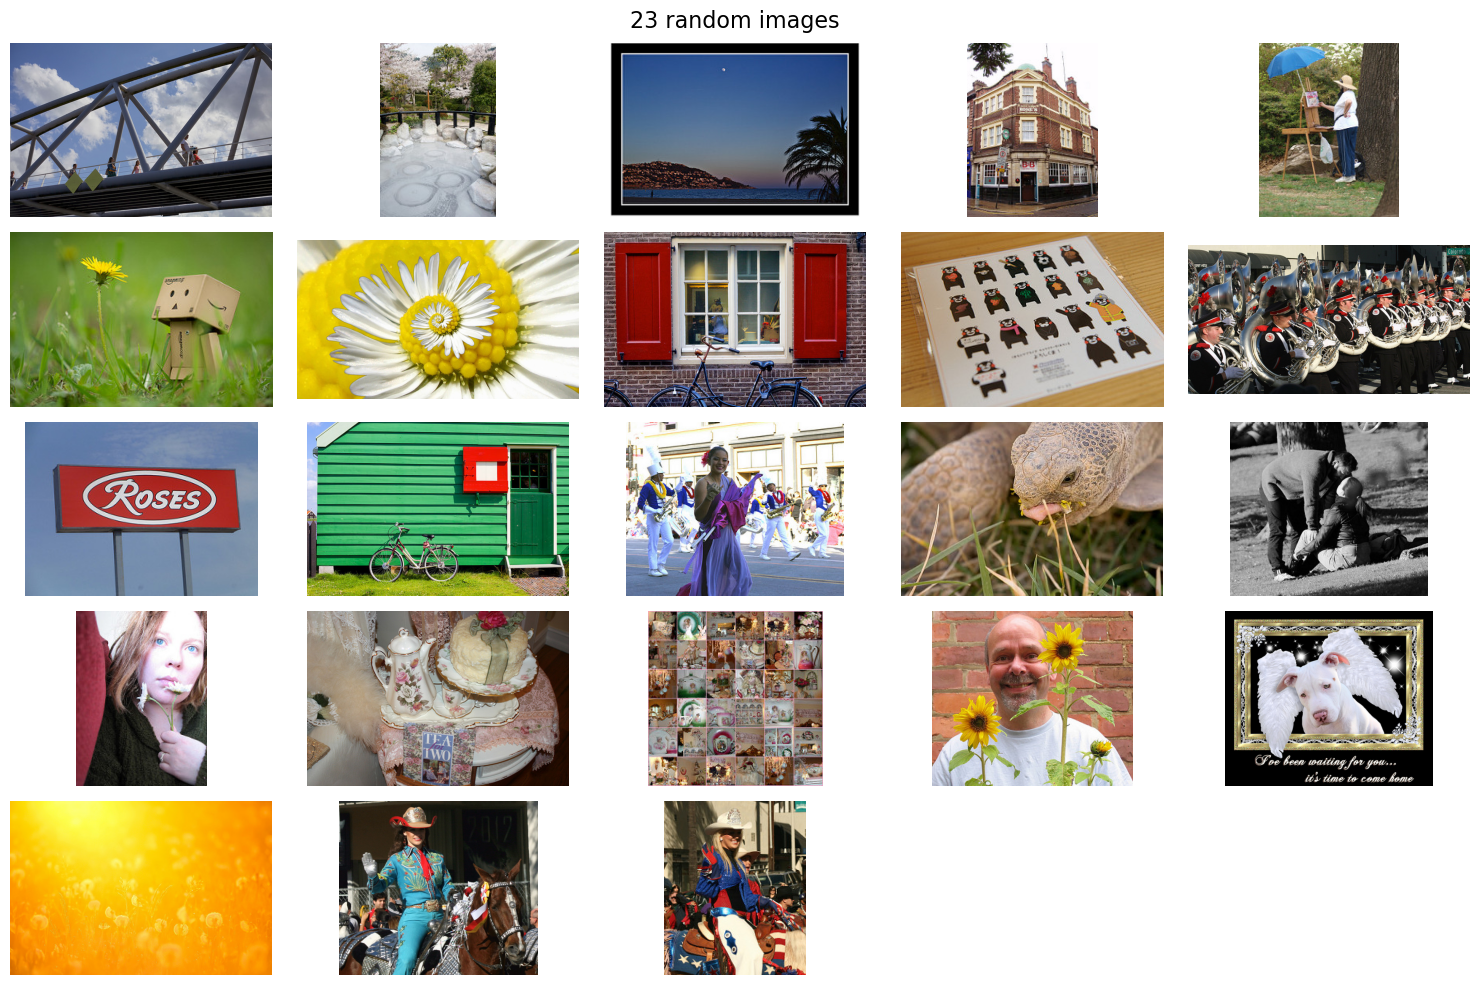

In [22]:
show_images(images_favorites, 23)

In [ ]:
def check_image_sizes(images):
    sizes = []
    
    for img in images:
        try:
            sizes.append(img.size)
        except Exception as e:
            print(f"Problem with: {img}, exception: {e}")
    
    size_counts = Counter(sizes)
    
    print(f"Number of unique sizes: {len(size_counts)}")
    print("Most popular sizes (top 5):")
    for size, count in size_counts.most_common(5):
        print(f"  {size}: {count} images")
    
    return sizes, size_counts

In [ ]:
sizes, size_counts = check_image_sizes(images_train)

Since it turned out that our images have very different sizes and from visual observations we decided to scale them instead of of cutting, because there are many pictures where the flowers are small parts of pictures located in the corners.

In [ ]:
def resize_images(imag, size=(224, 224)):
    images = []
    for img in imag:
        try:
            img = img.resize(size)
            images.append(img)
        except Exception as e:
            print(f"Error {path}: {e}")
    return images

In [ ]:
img_train=resize_images(images_train)
show_images(img_train,20)

In [ ]:
img_test=resize_images(images_test)

In [ ]:
X_train = np.array([np.array(img) for img in img_train])
X_test = np.array([np.array(img) for img in img_test])

## Analysing images' features

In [ ]:
r_channel = X_train[:, :, :, 0].flatten()
g_channel = X_train[:, :, :, 1].flatten()
b_channel = X_train[:, :, :, 2].flatten()

plt.figure(figsize=(12, 5))
plt.hist(r_channel, bins=50, color='red', alpha=0.5, label='Red')
plt.hist(g_channel, bins=50, color='green', alpha=0.5, label='Green')
plt.hist(b_channel, bins=50, color='blue', alpha=0.5, label='Blue')
plt.title("Distribution of RGB canals (all pixels)")
plt.xlabel("Pixel value (0-255)")
plt.ylabel("Number of pixels")
plt.legend()
plt.grid(True)
plt.show()

From the graph above we can conclude that:  
- we have little blues  
- there are some moderate greens  
- many pixels are intensively red

In [ ]:
grayscale_count = 0
for img in X_train:
    if np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2]):
        grayscale_count += 1

print(f"Black and white images: {grayscale_count} z {len(X_train)}")

Less than 1% of images from the train set are black and white so we could delete them if it poses problems later.

In [ ]:
def top_images(X, top_n, feature_name, feature, top=True):
    if (top):
        sorted_indices = np.argsort(feature)[::-1]
    else:
        sorted_indices = np.argsort(feature)
    
    top_n = 9
    top_images = [X[i] for i in sorted_indices[:top_n]]
    
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(top_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{feature_name}: {feature[sorted_indices[i]]:.1f}")
    plt.suptitle(f"Top {top_n} Images", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_avg_saturation(X):
    sat_vals = []
    for img in X:
        hsv = mcolors.rgb_to_hsv(img / 255.0)
        sat_vals.append(hsv[:, :, 1].mean())
    return np.array(sat_vals)

avg_saturation_test = compute_avg_saturation(X_test)
avg_saturation = compute_avg_saturation(X_train)
plt.hist(avg_saturation, bins=30, color='violet')
plt.title("Histogram of mean saturation")
plt.xlabel("Saturation (0–1)")
plt.ylabel("Image count")
plt.show()

In [ ]:
top_images(X_train, 9, "saturation", avg_saturation)

In [ ]:
top_images(X_train, 9, "saturation", avg_saturation, False)

In [ ]:
brightness = []
for img in X_train:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness.append(hsv[:, :, 2].mean())

brightness_test = []
for img in X_test:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness_test.append(hsv[:, :, 2].mean())


plt.hist(brightness, bins=50, color='orange')
plt.title("Distribution of brightness (V)")
plt.xlabel("Mean brightness (0–255)")
plt.ylabel("Image count")
plt.grid(True)
plt.show()

In [ ]:
top_images(X_train, 9, "brightness", brightness)

In [ ]:
top_images(X_train, 9, "brightness", brightness, False)

In [ ]:
variances_test = [img.var() for img in X_test]
variances = [img.var() for img in X_train]
plt.hist(variances, bins=50, color='teal')
plt.title("Distribution of variance")
plt.xlabel("Variance of pixels")
plt.ylabel("Image count")
plt.grid(True)
plt.show()

In [ ]:
top_images(X_train, 9, "variance", variances)

In [ ]:
top_images(X_train, 9, "variance", variances, False)

In [ ]:
def compute_entropy_from_numpy(images):
    entropies = []
    for img in images:
        gray = rgb2gray(img)
        entropy = shannon_entropy(gray)
        entropies.append(entropy)
    return entropies

entropies = compute_entropy_from_numpy(X_train)
entropies_test = compute_entropy_from_numpy(X_test)

Saturation, brightness and variance have an almost normal distribution. Images with marginal values of those features still look good, so we won't cut them from our dataset.

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(entropies, bins=50, color='teal', alpha=0.7)
plt.title("Distribution of entropy in the dataset")
plt.xlabel("Entropy (Shannon)")
plt.ylabel("Image count")
plt.grid(True)
plt.show()

Entropy values are high in most of the images, which means they are highly detailed.

# Feature engineering

## Our calculated features

In [ ]:
df_our_features = pd.DataFrame({
    "avg_saturation": avg_saturation,
    "brightness": brightness,
    "variance": variances,
    "entropy": entropies
})
df_our_features_test = pd.DataFrame({
    "avg_saturation": avg_saturation_test,
    "brightness": brightness_test,
    "variance": variances_test,
    "entropy": entropies_test
})
df_our_features.head()

## ResNet features

In [ ]:
resnet = models.resnet50(pretrained=True)

resnet = torch.nn.Sequential(*list(resnet.children())[:-1]);
resnet.eval();

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
features = []

with torch.no_grad():
    for img in X_train:
        x = transform(img).unsqueeze(0)
        feat = resnet(x)
        feat = feat.view(-1).numpy()
        features.append(feat)

In [ ]:
features_test = []

with torch.no_grad():
    for img in X_test:
        x = transform(img).unsqueeze(0)
        feat = resnet(x)
        feat = feat.view(-1).numpy()
        features_test.append(feat)

In [ ]:
df_resnet_features = pd.DataFrame(features)
df_resnet_features.columns = [f"resnet_feat_{i}" for i in range(df_resnet_features.shape[1])]

In [ ]:
df_resnet_features_test = pd.DataFrame(features_test)
df_resnet_features_test.columns = [f"resnet_feat_{i}" for i in range(df_resnet_features_test.shape[1])]

In [ ]:
df_features = pd.concat([
    df_resnet_features,
    df_our_features
], axis=1)

In [ ]:
df_features_test = pd.concat([
    df_resnet_features_test,
    df_our_features_test
], axis=1)

In [ ]:
df_features.head()

In [ ]:
scaler = StandardScaler()
df_features = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=df_features.columns
)
df_features_test = pd.DataFrame(
    scaler.transform(df_features_test),
    columns=df_features_test.columns
)

## PCA, t-SNE and UMAP

In [ ]:
features = df_features.values
features_test = df_features_test.values
tsne = TSNE(n_components=2, random_state=72, perplexity=20, n_iter=1000)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], s=10, alpha=0.7)
plt.title("t-SNE visualization of features")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=1000, random_state=72)
pca.fit(features)
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1

print(f"For 90% variance we need {n_components_90} components")

plt.figure(figsize=(10, 4))
plt.plot(cum_var, label='Cumulative variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f'{n_components_90} components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ft = range(n_components_90)
plt.bar(ft, pca.explained_variance_[:n_components_90])
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(np.arange(0, n_components_90, 20))
plt.show()

In [ ]:
pca = PCA(n_components=193, random_state=72)
features_pca = pca.fit_transform(features)

In [ ]:
features_pca_test = pca.transform(features_test)

In [ ]:
tsne = TSNE(n_components=2, random_state=72, perplexity=20, n_iter=1500, init='pca')
features_tsne = tsne.fit_transform(features_pca)

plt.figure(figsize=(8,6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=10, alpha=0.7)
plt.title("PCA + t-SNE visualization")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=72)
features_umap = reducer.fit_transform(features_pca)

plt.figure(figsize=(8,6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=10, alpha=0.7)
plt.title("PCA + UMAP visualization")
plt.xlabel("UMAP dim 1")
plt.ylabel("UMAP dim 2")
plt.grid(True)
plt.show()

# Modeling

In [ ]:
def _KMeans(X, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X)
    return X, labels

def _Spectral(X, n_clusters):
    model = SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', random_state=42, affinity='nearest_neighbors')
    labels = model.fit_predict(X)
    return X, labels

def _Agglomerative(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X)
    return X, labels

def _GMM(X, n_components):
    model = GaussianMixture(n_components=n_components, random_state=42)
    labels = model.fit(X).predict(X)
    return X, labels

In [ ]:
def evaluate_clustering(X, labels):
    if len(set(labels)) > 1 and -1 not in set(labels):
        print("Silhouette Score:", silhouette_score(X, labels))
        print("Calinski-Harabasz Score:", calinski_harabasz_score(X, labels))
        print("Davies-Bouldin Score:", davies_bouldin_score(X, labels))
    else:
        print("Not enough clusters")

In [ ]:
def photos_in_clusters(cluster_labels, samples_per_cluster=8, X_train=X_train):
    num_clusters = np.max(cluster_labels) + 1
    
    plt.figure(figsize=(samples_per_cluster * 2, num_clusters * 2))
    
    for cluster_id in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        selected_indices = cluster_indices[:samples_per_cluster]
    
        for i, idx in enumerate(selected_indices):
            plt_idx = cluster_id * samples_per_cluster + i + 1
            ax = plt.subplot(num_clusters, samples_per_cluster, plt_idx)
            plt.imshow(X_train[idx])
            plt.axis('off')
    
            if i == 0:
                ax.text(-0.3, 0.5, f"Cluster {cluster_id}", va='center', ha='right',
                        fontsize=12, transform=ax.transAxes)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.15)
    plt.show()

In [ ]:
def plot_tsne_clusters(features_pca, model, title="t-SNE + Clustering", perplexity=18, n_iter=1000):
    tsne = TSNE(n_components=2, random_state=72, perplexity=perplexity, n_iter=n_iter)
    features_tsne = tsne.fit_transform(features_pca)

    if hasattr(model, "fit_predict"):
        cluster_labels = model.fit_predict(features_pca)
    elif hasattr(model, "fit") and hasattr(model, "predict"):
        model.fit(features_pca)
        cluster_labels = model.predict(features_pca)
    else:
        raise ValueError("Wrong model.")

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_umap_clusters(features_pca, model, n_neighbors=15, min_dist=0.1, title="UMAP + Clustering"):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=72)
    features_umap = reducer.fit_transform(features_pca)
    
    if hasattr(model, "fit_predict"):
        cluster_labels = model.fit_predict(features_umap)
    elif hasattr(model, "fit") and hasattr(model, "predict"):
        model.fit(features_umap)
        cluster_labels = model.predict(features_umap)
    else:
        raise ValueError("Wrong model.")
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(features_umap[:, 0], features_umap[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel("UMAP dim 1")
    plt.ylabel("UMAP dim 2")
    plt.grid(True)
    plt.show()

In [ ]:
def clustering_metrics_plots(X, model_class, **kwargs):
    score = []
    score_s = []
    score_c = []
    score_d = []

    for k in range(2, 20):
        if model_class.__name__ == "GaussianMixture":
            model = model_class(n_components=k, **kwargs)
            model.fit(X)
            labels = model.predict(X)
            try:
                score.append(model.score(X))
            except:
                score.append(None)
        else:
            model = model_class(n_clusters=k, **kwargs)
            labels = model.fit_predict(X)
            if hasattr(model, "score"):
                try:
                    score.append(model.score(X))
                except:
                    score.append(None)
            else:
                score.append(None)

        score_s.append(silhouette_score(X, labels, metric='euclidean'))
        score_c.append(calinski_harabasz_score(X, labels))
        score_d.append(davies_bouldin_score(X, labels))

    metrics = [score, score_s, score_c, score_d]
    titles = ['Model Score (log-likelihood or inertia)', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin']

    for metric, title in zip(metrics, titles):
        x_ticks = list(range(2, len(metric) + 2))
        plt.plot(x_ticks, metric, 'bx-')
        plt.xlabel('k')
        plt.ylabel(title)
        plt.title(f'{title} vs k')
        plt.grid(True)
        plt.show()

In [ ]:
def plot_clusters(X, labels, title="", **kwargs):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

In [ ]:
def plot_all_clusters(X, n_cluster):
    plot_clusters(*_KMeans(X, n_clusters=n_cluster), title="k-Means")
    plot_clusters(*_Spectral(X, n_clusters=n_cluster), title="Spectral Clustering")
    plot_clusters(*_Agglomerative(X, n_clusters=n_cluster), title="Agglomerative Clustering")
    plot_clusters(*_GMM(X, n_components=n_cluster), title="Gaussian Mixture")

In [ ]:
def evaluate_all_models(X, n_clusters):
    models = {
        "KMeans": _KMeans,
        "Spectral": _Spectral,
        "Agglomerative": _Agglomerative,
        "Gaussian Mixture": _GMM
    }

    for name, func in models.items():
        print(f"--- {name} ---")
        try:
            _, labels = func(X, n_clusters)
            evaluate_clustering(X, labels)
        except Exception as e:
            print(f"Error in {name}: {e}")
        print()

In [ ]:
plot_all_clusters(features_pca, n_cluster=6)

In [ ]:
evaluate_all_models(features_pca, 6)

## KMeans

In [ ]:
clustering_metrics_plots(features_pca, KMeans, random_state=42)

From that we decided on 8 clusters.

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=72)

In [ ]:
plot_tsne_clusters(features_pca, kmeans, title="t-SNE + K-Means clustering")

In [ ]:
plot_umap_clusters(features_pca, kmeans, title="UMAP + K-Means clustering")

In [ ]:
cluster_labels = kmeans.fit_predict(features_pca)

photos_in_clusters(cluster_labels)

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} images")

In [ ]:
df = pd.DataFrame({'labels': cluster_labels, 'species': labels_train})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

In [ ]:
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
def kmeans_grid_search(X,
                       init_list=["k-means++", "random"],
                       n_init_list=[10, 20],
                       algo_list=["lloyd", "elkan"],
                       max_iter_list=[300],
                       scoring="silhouette"):

    best_score = -np.inf if scoring != "davies" else np.inf
    best_model = None
    best_results = None

    for ini, n_i, alg, it in product(init_list, n_init_list, algo_list, max_iter_list):
        try:
            km = KMeans(
                n_clusters=8,
                init=ini,
                n_init=n_i,
                algorithm=alg,
                max_iter=it,
                random_state=42,
            )
            labels = km.fit_predict(X)

            sil = silhouette_score(X, labels)
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)

            metric_map = {
                "silhouette": sil,
                "calinski": calinski,
                "davies": -davies
            }

            score = metric_map[scoring]

            if score > best_score:
                best_score = score
                best_model = km
                best_results = {
                    "labels": labels,
                    "n_clusters": 8,
                    "init": ini,
                    "n_init": n_i,
                    "algorithm": alg,
                    "max_iter": it,
                    "score": score,
                    "metric": scoring,
                    "silhouette": sil,
                    "calinski": calinski,
                    "davies": davies
                }

        except Exception as e:
            print(f"Error for init={ini}, n_init={n_i}, algo={alg}, max_iter={it}: {e}")

    if best_results:
        print(f"\nBest KMeans config:")
        for k, v in best_results.items():
            if k != "labels":
                print(f"   {k}: {v}")

    return best_model


In [ ]:
best_kmeans = kmeans_grid_search(features_pca, scoring='silhouette')

In [ ]:
cluster_labels = best_kmeans.fit_predict(features_pca)
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
photos_in_clusters(cluster_labels)

## Spectral Clustering

In [ ]:
clustering_metrics_plots(
    features_pca,
    SpectralClustering,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=72,
    n_init=5
)

From that we decided on 8 clusters.

In [ ]:
spectral = SpectralClustering(n_clusters=8,
                                 affinity='nearest_neighbors',
                                 n_neighbors=10,
                                 assign_labels='kmeans',
                                 random_state=72,
                                 n_init=5)

In [ ]:
plot_tsne_clusters(features_pca, spectral, title="t-SNE + Spectral clustering")

In [ ]:
plot_umap_clusters(features_pca, spectral, title="UMAP + Spectral clustering")

In [ ]:
cluster_labels = spectral.fit_predict(features_pca)

photos_in_clusters(cluster_labels)

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} images")

In [ ]:
df = pd.DataFrame({'labels': cluster_labels, 'species': labels_train})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

In [ ]:
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
def spectral_grid_search(X, n_clusters=8, scoring='silhouette'):
    param_grid = {
        'affinity': ['nearest_neighbors'],
        'assign_labels': ['kmeans', 'discretize'],
        'n_neighbors': range(2, 10),
        'n_init': range(3, 7)
    }

    best_score = -np.inf
    best_model = None
    best_params = None

    for affinity, assign_labels, n_neighbors, n_init in itertools.product(
        param_grid['affinity'],
        param_grid['assign_labels'],
        param_grid['n_neighbors'],
        param_grid['n_init']
    ):
        try:
            model = SpectralClustering(
                n_clusters=n_clusters,
                affinity=affinity,
                assign_labels=assign_labels,
                n_neighbors=n_neighbors,
                n_init=n_init,
                random_state=72
            )
            labels = model.fit_predict(X)

            sil_score = silhouette_score(X, labels)

            if sil_score > best_score:
                best_score = sil_score
                best_model = model
                best_params = {
                    'affinity': affinity,
                    'assign_labels': assign_labels,
                    'n_neighbors': n_neighbors,
                    'n_init': n_init,
                    'silhouette_score': sil_score
                }

        except Exception as e:
            print(f"Error with {affinity}, {assign_labels}, n_neighbors={n_neighbors}, n_init={n_init}: {e}")

    print(f"\nBest SpectralClustering config:")
    for k, v in best_params.items():
        print(f"   {k}: {v}")

    return best_model


In [ ]:
best_spectral = spectral_grid_search(features_pca, n_clusters=8)

In [ ]:
cluster_labels = best_spectral.fit_predict(features_pca)
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
photos_in_clusters(cluster_labels)

## Agglomerative Clustering

In [ ]:
clustering_metrics_plots(features_pca, AgglomerativeClustering)

From that we decided on 8 clusters.

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=8)

In [ ]:
plot_tsne_clusters(features_pca, agglomerative, title="t-SNE + Agglomerative clustering")

In [ ]:
plot_umap_clusters(features_pca, agglomerative, title="UMAP + Agglomerative clustering")

In [ ]:
cluster_labels = agglomerative.fit_predict(features_pca)

photos_in_clusters(cluster_labels)

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} images")

In [ ]:
df = pd.DataFrame({'labels': cluster_labels, 'species': labels_train})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

In [ ]:
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
def agglomerative_grid_search(X, 
                             affinity_list=["euclidean", "manhattan", "cosine"],
                             linkage_list=["ward", "complete", "average", "single"],
                             compute_full_tree_list=[True, False],
                             scoring="silhouette"):

    best_score = -np.inf if scoring != "davies" else np.inf
    best_config = None
    best_model = None

    for aff, link, full_tree in product(affinity_list, linkage_list, compute_full_tree_list):
        try:
            if link == "ward" and aff != "euclidean":
                continue

            model = AgglomerativeClustering(
                n_clusters=8,
                affinity=aff,
                linkage=link,
                compute_full_tree=full_tree
            )
            labels = model.fit_predict(X)

            sil = silhouette_score(X, labels)
            calinski = calinski_harabasz_score(X, labels)
            davies = davies_bouldin_score(X, labels)

            metric_map = {
                "silhouette": sil,
                "calinski": calinski,
                "davies": -davies
            }

            score = metric_map[scoring]

            if score > best_score:
                best_score = score
                best_config = {
                    "n_clusters": 8,
                    "affinity": aff,
                    "linkage": link,
                    "compute_full_tree": full_tree,
                    "score": score,
                    "metric": scoring,
                    "silhouette": sil,
                    "calinski": calinski,
                    "davies": davies,
                    "labels": labels
                }
                best_model = model

        except Exception as e:
            print(f"Error for affinity={aff}, linkage={link}, compute_full_tree={full_tree}: {e}")

    if best_config:
        print(f"\nBest AgglomerativeClustering config:")
        for param, val in best_config.items():
            if param != "labels":
                print(f"   {param}: {val}")

    return best_model

In [ ]:
best_agglomerative = agglomerative_grid_search(features_pca, scoring="calinski");

In [ ]:
cluster_labels = best_agglomerative.fit_predict(features_pca)
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
photos_in_clusters(cluster_labels)

## Gaussian Mixture

In [ ]:
clustering_metrics_plots(features_pca, GaussianMixture)

From that we decided on 6 clusters.

In [ ]:
gmm = GaussianMixture(n_components=6, covariance_type="full")

In [ ]:
plot_tsne_clusters(features_pca, gmm, title="t-SNE + GMM clustering")

In [ ]:
plot_umap_clusters(features_pca, gmm, title="UMAP + GMM clustering")

In [ ]:
cluster_labels = gmm.fit_predict(features_pca)

photos_in_clusters(cluster_labels)

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} images")

In [ ]:
df = pd.DataFrame({'labels': cluster_labels, 'species': labels_train})
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

In [ ]:
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
def gmm_grid_search(X):
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    init_methods = ['kmeans', 'random']
    reg_covar_vals = [1e-6, 1e-4]
    n_init_vals = [1, 5]
    max_iter_vals = [100, 200]

    best_score = -1
    best_model = None
    best_params = {}

    results = []

    for cov, init, reg, n_init, max_iter in itertools.product(
        covariance_types,
        init_methods,
        reg_covar_vals,
        n_init_vals,
        max_iter_vals
    ):
        try:
            gmm = GaussianMixture(
                n_components=6,
                covariance_type=cov,
                init_params=init,
                reg_covar=reg,
                n_init=n_init,
                max_iter=max_iter,
                random_state=42
            )
            labels = gmm.fit_predict(X)

            if len(np.unique(labels)) < 2:
                continue

            sil = silhouette_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)

            result = {
                "k": 6,
                "covariance_type": cov,
                "init_params": init,
                "reg_covar": reg,
                "n_init": n_init,
                "max_iter": max_iter,
                "silhouette": sil,
                "calinski_harabasz": ch,
                "davies_bouldin": db
            }
            results.append(result)

            if sil > best_score:
                best_score = sil
                best_model = gmm
                best_params = result.copy()

        except Exception as e:
            print(f"Error for cov={cov}: {e}")

    print(f"\nBest GMM config:")
    for k, v in best_params.items():
        print(f"   {k}: {v}")

    return best_model

In [ ]:
best_gmm = gmm_grid_search(features_pca);

In [ ]:
cluster_labels = best_gmm.fit_predict(features_pca)
evaluate_clustering(features_pca, cluster_labels)

In [ ]:
photos_in_clusters(cluster_labels)

## Spectral Clustering on test

In [ ]:
cluster_labels = spectral.fit_predict(features_pca_test)
photos_in_clusters(cluster_labels, 20, X_train=X_test)

In [ ]:
cluster_labels = best_spectral.fit_predict(features_pca_test)
photos_in_clusters(cluster_labels, 20, X_train=X_test)

After analysing all of our models above we came to such conclusions:  
* all of our scores are poor reflections of how well our models work (we mostly evaluate them visually),
* choosing the best number of clusters was also pretty difficult based on the graphs, we tried our best to identify crucial points,
* we decided to choose one of the spectral clustering models.